# Setup

### Load Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import datetime

from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev
from scipy.stats import linregress

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mticker
import matplotlib.patches as patches

import numpy as np

from os import walk

from IPython.display import HTML   

from numpy import interp

import rasterio as rs
from rasterio.plot import show
import rasterio.mask

import fiona

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import textwrap as tw

encoding = "utf_8"

### Definitions

In [2]:
gasses = ['CO2','CH4','N2O']
gas_units = {'CO2' : 'ppm','CH4' : 'ppb', 'N2O' : 'ppb'}

### Utility Functions

In [3]:
# convert a string to an int if it can be
# otherwise keep it a string

def stoi(s):
    try: 
        si = int(s)
        return si
    except ValueError:
        return s

# Estimating Animal Ag Emissions

### FAOSTAT Country Data

We need to use a consistent set of countries and country names. We use the FAOSTAT country list as our reference, and have accumulated a set of alternative names, punctuations and spellings from other datasets that we load here and use throughout.

In [4]:
country_group = pd.read_csv("FAOSTAT/FAOSTAT_Country_Group.csv",encoding = encoding)
fao_countries = list((pd.read_csv("Inputs/fao_countries.csv", encoding = encoding))['Area'].unique())

country_aliases = pd.read_csv("Inputs/country_aliases.csv",encoding = encoding)
country_alias_map = {}

for i,r in country_aliases.iterrows():
    country_alias_map[r['Alias']] = r['FAO Country']

for faoc in fao_countries:
    country_alias_map[faoc] = faoc

### Species and Production Emissions Data From Global GLEAM 2.0 

We use data from the United Nations Food and Agriculture Organization (FAO) Global Livestock Environmental Assessment Model [GLEAM](http://www.fao.org/gleam/resources/en/), version 2.0, to estimate gloabl emissions from animal agriculture. 

GLEAM is a modelling framework that simulates the interaction of activities and processes involved in livestock production and the environment. It was designed to allow policymakers to study the environmental consequences of changes in different steps of livestock supply chains. But we make use only of its baseline model of emissions broken down by species, product and region. 

We use the public data [available here]( http://www.fao.org/fileadmin/user_upload/gleam/docs/GLEAM_Data_public_release.xlsx).



In [5]:
# This is a lookup table to connect category, product and production process from GLEAM to species/product pairs

commodity_info = pd.DataFrame( data = 
    [
        ['Meat','buffalo_meat','Buffalo','All systems','Whole herd'],
        ['Meat','cattle_meat','Cattle','All systems','Whole herd'],
        ['Meat','chicken_meat','Chickens','All systems','Whole herd'],
        ['Meat','duck_meat','Chickens','All systems','Whole herd'], # no GLEAM data so use Chickens
        ['Meat','goat_meat','Goats', 'All systems','Whole herd'],
        ['Meat','sheep_meat','Sheep', 'All systems','Whole herd'],
        ['Meat','pig_meat','Pigs', 'All systems','Whole herd'],
        ['Milk','buffalo_milk','Buffalo','All systems','Dairy'],
        ['Milk','cow_milk','Cattle','All systems','Whole herd'],
        ['Milk','goat_milk','Goats','All systems','Whole herd'],
        ['Milk','sheep_milk','Sheep','All systems','Whole herd'],
        ['Eggs','eggs','Chickens','All systems','Whole herd']
    ],
    columns = ['Product Type','Category','Species','System','Type']
            
)

In [6]:
prods = ['Meat','Milk','Eggs']

gleam_var = {
    'Meat' : 'PROD: Meat - carcass weight', 
    'Milk' : 'PROD: Milk - fresh weight', 
    'Eggs' : 'PROD: Eggs - shell weight'
}

In [7]:
# GLEAM expresses gas-specific emission intensities in terms of emissions per unit protein
# These factors, which are derived from data in GLEAM, allow for conversion of protein units to FAO production units 
# carcass weight for meat
# liquid weight for milk
# shell weight for eggs

# use data from old version of GLEAM to get conversion from protein to production units

gleamall = pd.read_csv("GLEAM/GLEAM.csv", encoding=encoding)
df = pd.pivot_table(gleamall,index=['Species','System','Country','Type'],columns=['Variable'],aggfunc={'Value' : sum}).reset_index()
df.columns = df.columns = [c[0] for c in df.columns[0:4]] + [c[1] for c in df.columns[4:]]
df = df.groupby(['Species']).sum().reset_index()
df['CONV: Eggs'] = df['PROD: Eggs - shell weight']/df['PROD: Eggs - protein amount']
df['CONV: Milk'] = df['PROD: Milk - fresh weight']/df['PROD: Milk - protein amount']
df['CONV: Meat'] = df['PROD: Meat - carcass weight']/df['PROD: Meat - protein amount']
df[['Species'] + [c for c in df.columns if c.startswith('CONV')]]

data = []
for i,r in df.iterrows():
    for c in ['Eggs','Milk','Meat']:
        if r['CONV: %s' %c] > 0:
            data.append([r.Species,c,r['CONV: %s' %c]])
            
conversions = pd.DataFrame(data=data,columns=['Species','Commodity','Conversion'])
conversions = conversions.set_index(['Species','Commodity'])
conversions.loc[('Buffalo','Milk'),'Conversion'] = conversions.loc[('Cattle','Milk')]['Conversion']
conversions = conversions.reset_index()

In [8]:
conversions

,Species,Commodity,Conversion
0,Buffalo,Milk,29.656719
1,Buffalo,Meat,6.928637
2,Cattle,Milk,29.656719
3,Cattle,Meat,6.506834
4,Chickens,Eggs,8.064516
5,Chickens,Meat,7.017544
6,Goats,Milk,26.690530
7,Goats,Meat,7.440476
8,Pigs,Meat,7.616146
9,Sheep,Milk,16.485994


In [9]:
gleam2 =  pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "GLEAM_GRL", skiprows=2)

# harmonize  names

gleam2.loc[gleam2[gleam2.Species == "Buffaloes"].index,'Species'] = "Buffalo"
gleam2.loc[gleam2[gleam2.Species == "Chicken"].index,'Species'] = "Chickens"

# select products

gleam2 = gleam2[gleam2.Commodity.isin(prods)]
gleam2 = gleam2.merge(conversions,on=["Species","Commodity"],how="left")

for gas in gasses:
    gleam2['EI_%s_perkg' % (gas)] = gleam2['Total %s' % gas] / (gleam2['Production'] * gleam2['Conversion'])
gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")]
df = gleam2[(gleam2.Region == "Global") & (gleam2.System == "Aggregated")].copy()

# adjust CO2eq --> Gt (CO2) or Mt (CH4 and N2O)
for c in df:
    if 'CO2' in c and 'EI' not in c:
        df[c] = df[c] / 1E+12
        
    if 'CH4' in c and 'EI' not in c:
        df[c] = df[c] / (34 * 1E+9)
        
    if 'N2O' in c and 'EI' not in c:
        df[c] = df[c] / (298 * 1E+9)

In [10]:
gleam2_c = pd.read_excel(open("GLEAM/GLEAM_Data_public_release.xlsx", 'rb'),sheet_name = "COUNTRY_LIST", index_col=None, header=None, names=["Country"])

data = []
region = ""

for i,r in gleam2_c.iterrows():
    if r.Country[0:3] == "   ":
        data.append([region,r.Country[3:]])
    else:
        region = r.Country
        
gleam2_countries = pd.DataFrame(data=data,columns=['Region','Country'])

gleam2['Region'] = gleam2['Region'].str.upper()
gleam2c = gleam2_countries.merge(gleam2,on="Region",how='left')
gleam2c = gleam2c[gleam2c.System == "Aggregated"]

gleam2c['Country Mapped'] = gleam2c['Country'].map(country_alias_map)
gleam2c_countries = gleam2c['Country Mapped'].unique()

gleam2c = gleam2c[['Country Mapped','Species', 'System', 'Commodity', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']]
gleam2c.columns = ['Area','Species', 'System', 'Product', 'EI_CO2_perkg', 'EI_CH4_perkg', 'EI_N2O_perkg']

### Load FAO Primary Production Data

In [11]:
datafile = "Inputs/FAOSTAT_production_categories.csv"
fao_production_categories = pd.read_csv(datafile,encoding = encoding)
        
datafile = "FAOSTAT/Filtered/Production_LivestockPrimary_E_All_Data_(Normalized).csv"

fao_livestock_primary = pd.read_csv(datafile,encoding = "latin_1")
    
year = np.max(fao_livestock_primary.Year.values)
fao_livestock_primary = fao_livestock_primary[
        (fao_livestock_primary.Area.isin(fao_countries)) 
        & (fao_livestock_primary.Year == year) 
        & (fao_livestock_primary.Element == 'Production' ) 
        & (fao_livestock_primary.Unit == "tonnes")]
fao_livestock_primary.Value = fao_livestock_primary.Value.astype('Int64')
fao_livestock_primary = fao_livestock_primary.merge(fao_production_categories, on = "Item")
fao_livestock_primary['Primary Production'] = fao_livestock_primary['Value'] * fao_livestock_primary['Category Weight']
fao_livestock_primary = fao_livestock_primary[['Area','Category','Primary Production']].groupby(['Area','Category']).sum().reset_index()

### Join GLEAM and FAO Livestock Data to Estimate Current Animal Ag Emissions

In [12]:
livestock_data = fao_livestock_primary.copy()

incols = list(livestock_data.columns)

# create columns for Emissions data
for gas in gasses:
    livestock_data['Emissions|%s' % gas] = 0

livestock_data = livestock_data.merge(commodity_info,on="Category",how="left")
livestock_data = livestock_data.merge(gleam2c, 
            left_on=['Area','Product Type','Species'], 
            right_on=['Area','Product','Species'],
            how="left")

# GLEAM uses AR5 numbers for GWP
gwp = {
    'CO2' : 1,
    'CH4' : 34,
    'N2O' : 298
}

# scale from Gt --> Mt for CH4 and N2O

scale = {
    'CO2' : 1,
    'CH4' : 1000,
    'N2O' : 1000
}


for gas in gasses:
    livestock_data['Emissions|%s' % gas] =  ( livestock_data['Primary Production'] 
    * livestock_data['EI_%s_perkg' % (gas)] 
    * scale[gas]
    / gwp[gas]
    / 1E+09 )

    
livestock_data = livestock_data[incols + ['Emissions|%s' % gas  for gas in gasses]]

In [13]:
livestock_data.groupby('Category').sum()

,Primary Production,Emissions|CO2,Emissions|CH4,Emissions|N2O
Category,,,,
ass_meat,164977.0,0.0,0.0,0.0
buffalo_meat,4290212.0,0.02885,5.000432,0.198579
buffalo_milk,133752296.0,0.121331,10.872296,0.445477
camel_meat,685667.0,0.0,0.0,0.0
camel_milk,3111462.0,0.0,0.0,0.0
cattle_meat,68281663.0,0.615803,49.302813,2.412017
chicken_meat,123973557.0,0.440367,0.293461,0.52061
cow_milk,715871270.0,0.357411,37.680716,1.778157
duck_meat,7363110.0,0.036057,0.023576,0.049332


### Estimate Species, Product and Country-Specific Land Use

We use average land use data from Figure 1 of (Poore and Nemecek, 2018) to estimate land use associated with different species and products. We use data for cattle meat for buffalo meat, and cow milk for milk from buffalo, goat and sheep. The data are reported in million $m^2$/year/(100g protein) except for milk which is reported in $m^2$/year/liter which we convert to $m^2$/year/(kg primary production) using conversion factors inferred from GLEAM. As above, we used data on domestic production and trade to convert tonnes of primary production equivalents to land use. 

In [14]:
animal_land_data = [
       ['cattle_meat', 1640.0, 6.506834],
       ['buffalo_meat', 1640.0, 6.928637],
       ['goat_meat', 1000.0, 7.440476],
       ['sheep_meat', 1850.0, 7.096728],
       ['pig_meat', 110.0, 7.616146],
       ['chicken_meat', 71.0, 7.017544],
       ['duck_meat', 71.0, 7.017544],
       ['cow_milk', 8.9, 1],
       ['buffalo_milk', 8.9, 1],
       ['goat_milk', 8.9, 1 ],
       ['sheep_milk', 8.9, 1],
       ['eggs', 57.0, 8.06],
]

animal_land = pd.DataFrame(data=animal_land_data,columns=['Category','land use protein','protein ratio'])

# the 1000 is kg --> tonne
# the 1E+12 if m2 --> Mkm2
    
animal_land['land use per tonne'] = (animal_land['land use protein'] / animal_land['protein ratio']) * 1000 / 1E+12
incols = list(livestock_data.columns)
livestock_data = livestock_data.merge(animal_land,on="Category",how='left')
livestock_data['Land Use'] = livestock_data['Primary Production'] * livestock_data['land use per tonne']
livestock_data = livestock_data[incols + ['Land Use']]

In [15]:
livestock_data

,Area,Category,Primary Production,Emissions|CO2,Emissions|CH4,Emissions|N2O,Land Use
0,Afghanistan,camel_meat,3667.0,NaN,NaN,NaN,NaN
1,Afghanistan,camel_milk,6809.0,NaN,NaN,NaN,NaN
2,Afghanistan,cattle_meat,95398.0,0.001007,0.153158,0.005177,0.024044
3,Afghanistan,chicken_meat,28493.0,0.000099,0.000074,0.000171,0.000288
4,Afghanistan,cow_milk,1992114.0,0.001634,0.168724,0.006927,0.01773
...,...,...,...,...,...,...,...
1821,Zimbabwe,duck_meat,51.0,0.0,0.0,0.0,0.000001
1822,Zimbabwe,eggs,24480.0,0.000033,0.000174,0.000124,0.000173
1823,Zimbabwe,goat_meat,24829.0,0.000021,0.021145,0.000711,0.003337
1824,Zimbabwe,pig_meat,8891.0,0.000016,0.001005,0.000045,0.000128


In [16]:
livestock_data.to_csv("Outputs/livestock_data.csv",index=False)

### Start to Populate Emissions/Land Table

In [17]:
df = livestock_data.set_index(['Area','Category']).stack().reset_index()
df.columns = ['Area','Category','Item','Animal Ag']
emland_cat = df.groupby(['Category','Item']).sum().reset_index()
emland = df.groupby('Item').sum().reset_index()
emland = emland.set_index('Item')

In [18]:
emland

,Animal Ag
Item,
Emissions|CH4,122.766107
Emissions|CO2,2.25319
Emissions|N2O,6.996565
Land Use,33.026854
Primary Production,1304233500.0


## Emissions and Land Use of All Agriculture

In [19]:
datafile = "FAOSTAT/Filtered/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv"
fao_emissions = pd.read_csv(datafile,encoding = "latin_1")
fao_emissions = fao_emissions[fao_emissions.Area == "World"]
fao_emissions_pt = fao_emissions.pivot_table(index=['Item','Element','Unit'], columns=['Year'],aggfunc={'Value' : sum}).reset_index()
fao_emissions_pt.columns = [c[0] for c in fao_emissions_pt.columns[0:3]] + [c[1] for c in fao_emissions_pt.columns[3:]]
for y in [2018,2019]:
    fao_emissions_pt[y] = fao_emissions_pt[2000] + (y/2017) * (fao_emissions_pt[2017] - fao_emissions_pt[2000])
fao_emissions_pt = fao_emissions_pt.set_index(['Item','Element'])

In [20]:
df = livestock_data.set_index(['Area','Category']).stack().reset_index()
df.columns = ['Area','Category','Item','Bovid Ag']
emland_bov = df[df.Category.isin(['cattle_meat','cow_milk','buffalo_milk','buffalo_meat'])].groupby(['Item']).sum()

In [21]:
emland = emland.merge(emland_bov,on="Item")

In [22]:
emland ['All Ag'] = np.nan

emland.loc['Emissions|CO2','All Ag'] = fao_emissions_pt.loc[('Agriculture and related land use','CO2 emissions')][2019] / 1E+06
emland.loc['Emissions|CH4','All Ag'] = fao_emissions_pt.loc[('Agriculture total','CH4 emissions')][2019] / 1E+03
emland.loc['Emissions|N2O','All Ag'] = fao_emissions_pt.loc[('Agriculture total','N2O emissions')][2019] / 1E+03

# Direct from FAOSTAT
emland.loc['Land Use','All Ag'] = 4801370.2776 * 10 / 1000000

In [23]:
emland.loc['Emissions|CO2','Total'] = fao_emissions_pt.loc[('Total emissions with agricultural land use','CO2 emissions')][2018] / 1E+6
emland.loc['Emissions|CH4','Total'] = fao_emissions_pt.loc[('Total emissions with agricultural land use','CH4 emissions')][2018] / 1E+3
emland.loc['Emissions|N2O','Total'] = fao_emissions_pt.loc[('Total emissions with agricultural land use','N2O emissions')][2018] / 1E+3

In [24]:
emland['Non-Animal Ag'] = emland['All Ag'] - emland['Animal Ag']
emland['Food:Plant'] = 1.25 * emland['Non-Animal Ag']
emland['Food:BAU'] = emland['All Ag']

In [25]:
emland['Non-Bovid Ag'] = emland['All Ag'] - emland['Bovid Ag']
emland['Food:No Bovids'] = 1.15 * emland['Non-Bovid Ag']

In [26]:
emland

,Animal Ag,Bovid Ag,All Ag,Total,Non-Animal Ag,Food:Plant,Food:BAU,Non-Bovid Ag,Food:No Bovids
Item,,,,,,,,,
Emissions|CH4,122.766107,102.856257,142.119577,367.959165,19.353469,24.191837,142.119577,39.263319,45.152817
Emissions|CO2,2.25319,1.123395,4.531875,41.231054,2.278685,2.848357,4.531875,3.40848,3.919752
Emissions|N2O,6.996565,4.83423,7.828124,10.815596,0.831559,1.039449,7.828124,2.993893,3.442977
Land Use,33.026854,25.787032,48.013703,NaN,14.986848,18.73356,48.013703,22.22667,25.560671
Primary Production,1304233500.0,922195441.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Hayek Carbon Opportunity Cost Data

We don't use this directly in the current analyses, but this loads and computed country-specific data on land carbon opportunity cost by country

In [27]:
animal_coc = rs.open(r'Hayek/animal_COC.tif')
animal_coc_data = animal_coc.read()

animal_coc_data.shape
animal_coc_data = np.where(animal_coc_data < 0,0,animal_coc_data)

# data are in tons of C per ha but ha varies with latitude according to

lat = np.linspace(89.95833,-89.95833,2160)
ha = np.cos(lat * np.pi / 180) * 8586.325

animal_coc_data_ha = np.zeros(animal_coc_data.shape)

for i in range(0,animal_coc_data.shape[1]):
    for j in [0,1,2]:
        animal_coc_data_ha[j][i] = ha[i] * animal_coc_data[j][i]

hayek_plant_coc = np.zeros(3)

for j in [0,1,2]:
    hayek_plant_coc[j] = ha[i] * np.sum(animal_coc_data[j][i])
    
animal_ha = rs.open(r'Hayek/animal_hectares.tif')
animal_ha_data = animal_ha.read()

In [28]:
geometry = {}

shapefile = fiona.open("Hayek/World_Countries__Generalized_-shp/World_Countries__Generalized_.shp")

for feature in shapefile:
    country = dict(feature['properties'])['COUNTRY']
    geometry[country] = feature['geometry']

recompute_COC = False

if recompute_COC == True:    
    data = []

    for c in geometry:
        out_image, out_tranform = rasterio.mask.mask(animal_coc,[geometry[c]])
        mask_im = np.where(out_image>0,animal_coc_data_ha,0)
        coc = np.sum(mask_im[0]) / 1E+9
        out_image, out_tranform = rasterio.mask.mask(animal_ha,[geometry[c]])
        mask_im = np.where(out_image>0,animal_ha_data,0)
        ha = np.sum(mask_im[0])
        data.append([c,coc,ha])

    country_coc = pd.DataFrame(data=data,columns=['Country','COC','HA'])
    country_coc['RAT'] = 1000000 * country_coc['COC'] / country_coc['HA']
    
    country_coc.to_csv("Inputs/country_coc.csv", index=False)
    
else:
    country_coc = pd.read_csv("Inputs/country_coc.csv")

## Modeling Emission Scenarios and Atmospheric GHG Levels

In [29]:
model_years = np.arange(2020,2101)

halflife = {
    'CO2': 1000,
    'CH4': 9,
    'N2O': 115
}

annualdecay = {
    'CO2': 1,
    'CH4': np.power(.5,1/halflife['CH4']),
    'N2O': np.power(.5,1/halflife['N2O'])
}

nona = {
    'CO2' : 0,
    'CH4' : (1-annualdecay['CH4']) * 717.76,
    'N2O' : (1-annualdecay['N2O']) * 269.55
}

nona_fit = {
    'CO2' : 0,
    'CH4' : 25,
    'N2O' : 1.0 # 1.63 fits historical data
}

to_atm = {
    'CO2' : .5,
    'CH4' : 1,
    'N2O' : 1
}

to_Mt = {
    'CO2' : 1000,
    'CH4' : 1,
    'N2O' : 1
}

pp_scale = {
    'CO2' : (1/1000),
    'CH4' : 1,
    'N2O' : 1
}

mw = {
    'CO2' : 44,
    'CH4' : 16,
    'N2O' : 44
}

pp_start = {
    'CO2': 409.819034,
    'CH4': 1863.93445,
    'N2O': 332.538751
}

cr = {
    'CO2' : 1,
    'CH4' : 0,
    'N2O' : 0,
}

##  Radiative Forcing 

Radiative forcing (RF) is defined as the difference between solar irradiance absorbed by the Earth and energy radiated back to space. RF combines the warming influence of difference gasses together into a single number. It is measured in units of $Wm^{-2}$.

Increasing positive values of RF mean Earth is receiving correspondingly more incoming energy from sunlight than it radiates to space, causing increased warming. Strategies to mitigate global warming are often expressed in terms of RF targets.

Following [MAGICC](http://wiki.magicc.org/index.php?title=Radiative_Forcing) and IPCC AR5, we use the formula for Radiative Forcings as described in [Myhre et al. 1998](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01908) and [Ramaswamy et al., 2001](https://www.ipcc.ch/site/assets/uploads/2018/03/TAR-06.pdf).

For atmospheric concentrations of ${\rm CO_{2}}$ of ${\rm C}$ ppm, ${\rm CH_{4}}$ of ${\rm M}$ ppb, ${\rm N_{2}O}$ of ${\rm N}$ ppb. 

$\Delta F = \Delta F_{\rm CO_2}+\Delta F_{\rm CH_4}+\Delta F_{\rm N_{2}O}$ 

where:  

${\rm C_0}, {\rm M_0}, {\rm N_0}$ are the preindustrial concentrations of ${\rm CO_{2}}$ in ppm, ${\rm CH_{4}}$ in ppb, ${\rm N_{2}O}$ in ppb. 

$\Delta F_{\rm CO_2}=\alpha_{\rm CO_2}{\rm ln} (\rm C/C_0)$ 

$\Delta F_{\rm CH_4} = \alpha_{\rm CH_4}((1+\beta_{\rm CH_4})(\sqrt{\rm M}-\sqrt{\rm M_0})-f({\rm M},{\rm N_0})-f({\rm M_0},{\rm N_0})$

$\Delta F_{\rm N_2O} = \alpha_{\rm N_2O}(\sqrt{\rm N}-\sqrt{\rm N_0}-f({\rm M_0},{\rm N})-f({\rm M_0},{\rm N_0})$

$f(\rm M,N)=0.47{\rm ln}\,(1+0.6356(\frac{\rm MN}{10^6})^{0.75}+0.007\frac{\rm M}{10^3}(\frac{\rm MN}{10^6})^{1.52})$

$\alpha_{\rm CO_2}=5.35$

$\alpha_{\rm CH_4}=0.036$

$\beta_{\rm CH_4}=0.15$

$\alpha_{\rm N_{2}O}=0.12$


In [30]:
def F_MAGICC(M,N):
    F = 0.47 * np.log(1 + 0.6356 * np.power(M*N/1E6,0.75) + 0.007 * (M/1E3) * np.power(M*N/1E6,1.52))
    return F
    
def RF_MAGICC(C,M,N):
    
    C0 = 278
    M0 = 700
    N0 = 270
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0.15
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

# Scenario Modeling

In [31]:
scenarios = pd.DataFrame(data=model_years,columns=['Year'])

In [32]:
# Amount of carbon Hayek et al. estimate would be fixed over 30 years with a transformation to a plant only diet

# Reported in gigatonnes C

c_oc = 216

# convert gigatonnes C to gigatonnes CO2

co2_oc = c_oc * 44 / 12

## Immediate Cessation of Animal Agriculture

What happens if switched to a plant only diet immediately.

In Hayek they report that a vegan diet would lead to fixation of 547 Gt CO2 in living biomass and 225 Gt in ecosystems soil. They also report that a BAU diet would lead to a net release of 86 Gt CO2 to deal with increased land neads for animal agriculture. They don't discuss what the BAU soil carbon release would be, so we assume it scales then the soil carbon increase for BAU would 86 * 225 / 547 = 35. So total BAU would be 121 Gt CO2 over 30 years, consistent with current agricultural releases of 4 Gt per year, although of those only around half are allocated to animal ag.

In [33]:
co2_oc_burnin = 30
scenarios['CO2_recovery'] = 0
scenarios.loc[scenarios[scenarios.Year < 2020 + co2_oc_burnin].index,'CO2_recovery'] = co2_oc / co2_oc_burnin

In [34]:
scenarios['SCENARIO'] = "Fixed"
scenarios['Emissions|CO2|No Agriculture'] = emland.loc['Emissions|CO2']['Total'] - emland.loc['Emissions|CO2']['All Ag']
scenarios['Emissions|CH4|No Agriculture'] = emland.loc['Emissions|CH4']['Total'] - emland.loc['Emissions|CH4']['All Ag']
scenarios['Emissions|N2O|No Agriculture'] = emland.loc['Emissions|N2O']['Total'] - emland.loc['Emissions|N2O']['All Ag']
scenarios['Population'] = 7.600

In [35]:
emland_scenarios = emland.copy()
emland_scenarios.loc['Emissions|CO2','Food:Plant'] = 0
emland_scenarios.loc['Emissions|CO2','Food:BAU'] = 121/30

In [36]:
for gas in gasses:
    scenarios['Emissions|%s|Food|Baseline' % gas]   = emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|Food|Plant' % gas]      = emland_scenarios.loc['Emissions|%s' % gas]['Food:Plant']
    scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant' % gas]     = scenarios['Emissions|%s|Food|Plant' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant CR' % gas]  = scenarios['Emissions|%s|Total|Plant' % gas] - cr[gas] * scenarios['CO2_recovery']

In [37]:
tags = ['Baseline','Plant','Plant CR']
    
for scen,r in scenarios[scenarios.Year.isin(model_years)].groupby('SCENARIO'): 
    for gas in gasses:
        for tag in tags:
            ecol = 'Emissions|' + gas + '|Total|' + tag
            e = r[ecol].values
            p = e * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
            a = np.zeros(len(e))
            a[0] = pp_start[gas]
            for i in range(1,len(a)):
                a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona_fit[gas]
        
            scenarios.loc[r.index,'Concentration|%s|%s' % (gas,tag)] = a   
            
        
for f in tags:
    
    rfs = {}
    C = scenarios['Concentration|CO2|%s' % f].values
    M = scenarios['Concentration|CH4|%s' % f].values
    N = scenarios['Concentration|N2O|%s' % f].values
    
    (rfs['CO2'],rfs['CH4'],rfs['N2O'],rfs['TOTAL']) = RF_MAGICC(C,M,N)

    for gas in gasses:
        scenarios['RF|%s|%s' % (gas,f) ] = rfs[gas]
    
    scenarios['RF|%s' % f] = rfs['TOTAL']

## Phaseout of Animal Agriculture Over 15 Years

In [38]:
aa_phaseout = 15
phaseout = pd.DataFrame(data=model_years,columns=['Year'])
phaseout['aa_exponential_phaseout'] = np.clip( np.exp (-5 * np.power((phaseout.Year-2020)/aa_phaseout,3)),0,1)

# in Gt C

c_oc = 216

# convert C --> CO2

co2_oc = c_oc * 44 / 12

v = phaseout['aa_exponential_phaseout'].values
aa_exponential_phaseout_delta = np.append([0],v[:-1]-v[1:])

    # phase in CO2 recovery in proportion to animal ag phaseout
phaseout['CO2_recovery_frac_exponential'] = 0.0
y = phaseout['CO2_recovery_frac_exponential'].values

co2_oc_burnin = 30

for i in range(0,len(y)):
    d = aa_exponential_phaseout_delta[i] / float(co2_oc_burnin)
    for j in range(i,min(i+co2_oc_burnin,len(y))):
        y[j] += d
phaseout['CO2_recovery_frac_exponential'] = y
phaseout['CO2_recovery_phaseout'] = co2_oc * phaseout['CO2_recovery_frac_exponential']

scenarios = scenarios.merge(phaseout[['Year','aa_exponential_phaseout','CO2_recovery_frac_exponential','CO2_recovery_phaseout']],on="Year")


for gas in gasses:
    scenarios['Emissions|%s|Food|Baseline' % gas]   = emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU']
    scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]

    food_plant  =      scenarios['aa_exponential_phaseout']  * emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU'] 
    food_plant += (1 - scenarios['aa_exponential_phaseout']) * emland_scenarios.loc['Emissions|%s' % gas]['Food:Plant'] 
    
        
    scenarios['Emissions|%s|Food|Plant|Phaseout' % gas]  = food_plant
    scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant|Phaseout' % gas]  = scenarios['Emissions|%s|Food|Plant|Phaseout' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant CR|Phaseout' % gas] = scenarios['Emissions|%s|Total|Plant|Phaseout' % gas] - cr[gas] * scenarios['CO2_recovery_phaseout']    
    
    
tags = ['Baseline','Plant|Phaseout','Plant CR|Phaseout']
    
for scen,r in scenarios[scenarios.Year.isin(model_years)].groupby('SCENARIO'): 
    for gas in gasses:
        for tag in tags:
            ecol = 'Emissions|' + gas + '|Total|' + tag
            e = r[ecol].values
            p = e * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
            a = np.zeros(len(e))
            a[0] = pp_start[gas]
            for i in range(1,len(a)):
                a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona_fit[gas]
        
            scenarios.loc[r.index,'Concentration|%s|%s' % (gas,tag)] = a   
            
        
for f in tags:
    
    rfs = {}
    C = scenarios['Concentration|CO2|%s' % f].values
    M = scenarios['Concentration|CH4|%s' % f].values
    N = scenarios['Concentration|N2O|%s' % f].values
    
    (rfs['CO2'],rfs['CH4'],rfs['N2O'],rfs['TOTAL']) = RF_MAGICC(C,M,N)

    for gas in gasses:
        scenarios['RF|%s|%s' % (gas,f) ] = rfs[gas]
    
    scenarios['RF|%s' % f] = rfs['TOTAL']


## Phaseout of Animal Agriculture Over 15 Years with 50 Year Carbon Recovery

In [39]:
aa_phaseout = 15

phaseout = pd.DataFrame(data=model_years,columns=['Year'])
phaseout['aa_exponential_phaseout'] = np.clip( np.exp (-5 * np.power((phaseout.Year-2020)/aa_phaseout,3)),0,1)

# in Gt C

c_oc = 216

# convert C --> CO2

co2_oc = c_oc * 44 / 12

v = phaseout['aa_exponential_phaseout'].values
aa_exponential_phaseout_delta = np.append([0],v[:-1]-v[1:])

# phase in CO2 recovery in proportion to animal ag phaseout

co2_oc_burnin = 50

y = np.zeros(len(model_years))

for i in range(0,len(y)):
    d = aa_exponential_phaseout_delta[i] / float(co2_oc_burnin)
    for j in range(i,min(i+co2_oc_burnin,len(y))):
        y[j] += d
        
phaseout['CO2_recovery_frac_exponential_slow'] = y
phaseout['CO2_recovery_phaseout_slow'] = co2_oc * phaseout['CO2_recovery_frac_exponential_slow']

scenarios = scenarios.merge(phaseout[['Year','CO2_recovery_phaseout_slow']],on="Year")


for gas in gasses:
    #scenarios['Emissions|%s|Food|Baseline' % gas]   = emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU']
    #scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]

    #food_plant  =      scenarios['aa_exponential_phaseout']  * emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU'] 
    #food_plant += (1 - scenarios['aa_exponential_phaseout']) * emland_scenarios.loc['Emissions|%s' % gas]['Food:Plant'] 
    
        
    #scenarios['Emissions|%s|Food|Plant|Phaseout' % gas]  = food_plant
    #scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    #scenarios['Emissions|%s|Total|Plant|Phaseout' % gas]  = scenarios['Emissions|%s|Food|Plant|Phaseout' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant Slow CR|Phaseout' % gas] = scenarios['Emissions|%s|Total|Plant|Phaseout' % gas] - cr[gas] * scenarios['CO2_recovery_phaseout_slow']    
    
    
tags = ['Plant Slow CR|Phaseout']
    
for scen,r in scenarios[scenarios.Year.isin(model_years)].groupby('SCENARIO'): 
    for gas in gasses:
        for tag in tags:
            ecol = 'Emissions|' + gas + '|Total|' + tag
            e = r[ecol].values
            p = e * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
            a = np.zeros(len(e))
            a[0] = pp_start[gas]
            for i in range(1,len(a)):
                a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona_fit[gas]
        
            scenarios.loc[r.index,'Concentration|%s|%s' % (gas,tag)] = a   
            
        
for f in tags:
    
    rfs = {}
    C = scenarios['Concentration|CO2|%s' % f].values
    M = scenarios['Concentration|CH4|%s' % f].values
    N = scenarios['Concentration|N2O|%s' % f].values
    
    (rfs['CO2'],rfs['CH4'],rfs['N2O'],rfs['TOTAL']) = RF_MAGICC(C,M,N)

    for gas in gasses:
        scenarios['RF|%s|%s' % (gas,f) ] = rfs[gas]
    
    scenarios['RF|%s' % f] = rfs['TOTAL']


## Phaseout Bovids

In [40]:
emland_scenarios

,Animal Ag,Bovid Ag,All Ag,Total,Non-Animal Ag,Food:Plant,Food:BAU,Non-Bovid Ag,Food:No Bovids
Item,,,,,,,,,
Emissions|CH4,122.766107,102.856257,142.119577,367.959165,19.353469,24.191837,142.119577,39.263319,45.152817
Emissions|CO2,2.25319,1.123395,4.531875,41.231054,2.278685,0.0,4.033333,3.40848,3.919752
Emissions|N2O,6.996565,4.83423,7.828124,10.815596,0.831559,1.039449,7.828124,2.993893,3.442977
Land Use,33.026854,25.787032,48.013703,NaN,14.986848,18.73356,48.013703,22.22667,25.560671
Primary Production,1304233500.0,922195441.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
emland_scenarios.loc['Emissions|CO2','Food:No Bovids'] = .2 * 121/30

In [42]:
# in Gt C

c_oc = 216

# convert C --> CO2

co2_oc = c_oc * 44 / 12 

# for cattle

co2_oc = co2_oc * .785

scenarios['CO2_recovery_phaseout_nobovids'] = co2_oc * scenarios['CO2_recovery_frac_exponential']

In [43]:
for gas in gasses:
    #scenarios['Emissions|%s|Food|Baseline' % gas]   = emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU']
    #scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]

    food_plant  =      scenarios['aa_exponential_phaseout']  * emland_scenarios.loc['Emissions|%s' % gas]['Food:BAU'] 
    food_plant += (1 - scenarios['aa_exponential_phaseout']) * emland_scenarios.loc['Emissions|%s' % gas]['Food:No Bovids'] 
    
        
    scenarios['Emissions|%s|Food|Plant|Phaseout Bovids' % gas]  = food_plant
    #scenarios['Emissions|%s|Total|Baseline' % gas]  = scenarios['Emissions|%s|Food|Baseline' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant|Phaseout Bovids' % gas]  = scenarios['Emissions|%s|Food|Plant|Phaseout Bovids' % gas]   + scenarios['Emissions|%s|No Agriculture' % gas]
    scenarios['Emissions|%s|Total|Plant CR|Phaseout Bovids' % gas] = scenarios['Emissions|%s|Total|Plant|Phaseout Bovids' % gas] - cr[gas] * scenarios['CO2_recovery_phaseout_nobovids']    
    

In [44]:
tags = ['Baseline','Plant|Phaseout Bovids','Plant CR|Phaseout Bovids']
    
for scen,r in scenarios[scenarios.Year.isin(model_years)].groupby('SCENARIO'): 
    for gas in gasses:
        for tag in tags:
            ecol = 'Emissions|' + gas + '|Total|' + tag
            e = r[ecol].values
            p = e * to_Mt[gas] * 1.0E12 * (1/mw[gas]) * (1/1.8E11) * pp_scale[gas]
            a = np.zeros(len(e))
            a[0] = pp_start[gas]
            for i in range(1,len(a)):
                a[i] = a[i-1] * annualdecay[gas] + p[i-1] * to_atm[gas] + nona_fit[gas]
        
            scenarios.loc[r.index,'Concentration|%s|%s' % (gas,tag)] = a   
            
        
for f in tags:
    
    rfs = {}
    C = scenarios['Concentration|CO2|%s' % f].values
    M = scenarios['Concentration|CH4|%s' % f].values
    N = scenarios['Concentration|N2O|%s' % f].values
    
    (rfs['CO2'],rfs['CH4'],rfs['N2O'],rfs['TOTAL']) = RF_MAGICC(C,M,N)

    for gas in gasses:
        scenarios['RF|%s|%s' % (gas,f) ] = rfs[gas]
    
    scenarios['RF|%s' % f] = rfs['TOTAL']


## Current Global Food Supply from Plants and Animals

In [45]:
faocrops = pd.read_csv("FAOSTAT/Filtered/FoodSupply_Crops_E_All_Data_(Normalized).csv")
faocrops[(faocrops.Area == "World") & (faocrops.Year == 2013) & (faocrops.Item == "Grand Total")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
503,5000,World,2901,Grand Total,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,2884.00,Fc
504,5000,World,2901,Grand Total,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,81.23,Fc
505,5000,World,2901,Grand Total,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,82.76,Fc


In [46]:
faols = pd.read_csv("FAOSTAT/Filtered/FoodSupply_LivestockFish_E_All_Data_(Normalized).csv")
faols[(faols.Area == "World") & (faols.Year == 2013) & (faols.Item == "Animal Products")]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
154,5000,World,2941,Animal Products,664,Food supply (kcal/capita/day),2013,2013,kcal/capita/day,514.00,Fc
155,5000,World,2941,Animal Products,674,Protein supply quantity (g/capita/day),2013,2013,g/capita/day,32.13,Fc
156,5000,World,2941,Animal Products,684,Fat supply quantity (g/capita/day),2013,2013,g/capita/day,37.55,Fc


## Cross-check RF Calculation Against MAGICC Output in SSP/IAMs

In [47]:
ssp_iam = pd.read_csv("SSP/SSP_IAM_V2_201811.csv/SSP_IAM_V2_201811.csv")
iamc = ssp_iam.set_index(list(ssp_iam.columns[0:5]))
df = pd.DataFrame(data=iamc.stack()).reset_index()
df.columns = ['Model','Scenario','Region','Variable','Unit','Year','Value']
dfp = pd.pivot_table(df,index=['Model','Scenario','Region','Year'],columns='Variable',aggfunc={'Value' : sum}).reset_index()
dfp.columns = list([c[0] for c in dfp.columns[0:4]]) + list([c[1] for c in dfp.columns[4:]])

In [48]:
C = dfp['Diagnostics|MAGICC6|Concentration|CO2']
M = dfp['Diagnostics|MAGICC6|Concentration|CH4']
N = dfp['Diagnostics|MAGICC6|Concentration|N2O']

Carbon dioxide
Taking into account the "saturation" effect of CO2 forcing, i.e., the decreasing forcing efficiency for a unit increases of CO2 concentrations with higher background concentrations, the first IPCC Assessment (Shine et al., 1990) presented the simplified expression of the form:

$\label{eq_CO2_forcing} \Delta Q_{\rm CO_2}=\alpha_{\rm CO_2}{\rm ln} (\rm C/C_0)$(A35)
where $\Delta Q_{\rm CO_2}$ is the adjusted radiative forcing by CO2 (Wm-2) for a CO2 concentration $C$ (ppm) above the pre-industrial concentration $C$0 (278 ppm). This expression proved to be a good approximation, although the scaling parameter $\alpha_{\rm CO_2}$ has since been updated to a best-estimate of 5.35 Wm-2 (=$\frac{3.71}{ln(2)} $Wm-2)Myhre et al. (1998), used as default in MAGICC. When applying AOGCM-specific CO2 forcing, $\alpha_{\rm CO_2}$ is set to:

$\label{eq_CO2_forcing_dQ2x} \alpha_{\rm CO_2} = \frac{\Delta Q_{\rm 2\times}}{\rm ln(2)}$(A36)
Methane and nitrous oxide
Methane and nitrous oxide have overlapping absorption bands so that higher concentrations of one gas will reduce the effective absorption by the other and vice versa. This is reflected in the standard simplified expression for methane and nitrous oxide forcing, $\Delta Q_{\rm CH4}$ and $\Delta Q_{\rm N2O}$, respectively (see Ramaswamy et al., 2001, Myhre et al. 1998):

$\label{eq_methane_forcing}\Delta Q_{\rm CH_4} = \alpha_{\rm CH_4}(\sqrt{\rm C_{\rm CH_4}}-\sqrt{\rm C_{\rm CH_4}^0}-f(\rm C_{\rm CH_4},{\rm C}_{\rm N_2O}^0)-f({\rm C}_{\rm CH_4}^0,{\rm C}_{\rm N_2O}^0)$(A37)

$\Delta Q_{\rm N_2O} = \alpha_{\rm N_2O}(\sqrt{{\rm C}_{\rm N_2O}}-\sqrt{{\rm C}_{\rm N_2O}^0})-f({\rm C}_{\rm CH_4}^0,{\rm C}_{\rm N_2O})-f({\rm C}_{\rm CH_4}^0,{\rm C}_{\rm N_2O}^0)$(A38)
where the overlap is captured by the function

$\label{eq_methane_forcing_overlap}f(\rm M,N)=0.47{\rm ln}\,(1+0.6356(\frac{\rm MN}{10^6})^{0.75}+0.007\frac{\rm M}{10^3}(\frac{\rm MN}{10^6})^{1.52})$(A39)
with M and N being CH4 and N2O concentrations in ppb. For methane, an additional forcing factor due to methane-induced enhancement of stratospheric water vapor content is included. This enhancement is assumed to be proportional to (default $\beta$=15 %) the ``pure´´ methane radiative forcing, i.e., without subtraction of N2O absorption band overlaps:

$\Delta Q_{\rm CH_4}^{\rm stratoH2O} =\beta\alpha_{\rm CH_4}(\sqrt{\rm C_{\rm CH_4}}-\sqrt{\rm C_{\rm CH_4}^0}). $

Reported numbers don't include term for methane-induced enhancement of stratospheric water vapor so set $\beta$ to zero here

In [49]:
def RF_MAGICC_XC(C,M,N):
    
    C0 = 277.04
    M0 = 679
    N0 = 270.5
    
    AC = 5.35
    AM = 0.036
    AN = 0.12
    
    beta = 0
    
    rf_co2 = AC*np.log(C/C0) 
    rf_ch4 = AM*((1+beta) * (np.sqrt(M) - np.sqrt(M0)) - F_MAGICC(M,N0) - F_MAGICC(M0,N0))
    rf_n2o = AN*(np.sqrt(N) - np.sqrt(N0) - F_MAGICC(M0,N) - F_MAGICC(M0,N0))
    
    rf = rf_co2 + rf_ch4 + rf_n2o
    
    return(rf_co2,rf_ch4,rf_n2o,rf)

LRC,LRM,LRN,LR = RF_MAGICC_XC(C,M,N)
MRC = dfp['Diagnostics|MAGICC6|Forcing|CO2']
MRM = dfp['Diagnostics|MAGICC6|Forcing|CH4']
MRN = dfp['Diagnostics|MAGICC6|Forcing|N2O']
MRF = dfp['Diagnostics|MAGICC6|Forcing']
MR = MRC + MRM + MRN

Text(0, 0.5, 'LOCAL RF')

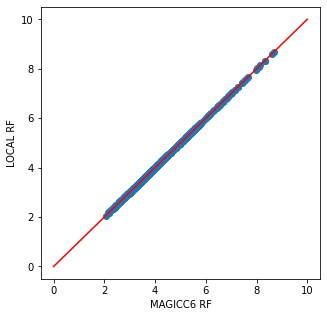

In [50]:
plt.figure(figsize=(5,5))
plt.scatter(MR,LR)
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),c='red')
plt.xlabel("MAGICC6 RF")
plt.ylabel("LOCAL RF")

Text(0, 0.5, 'LOCAL RF CO2')

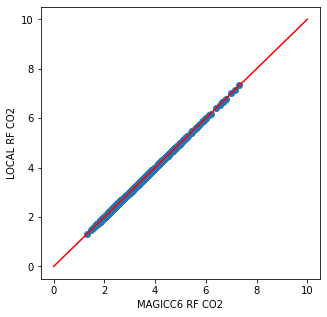

In [51]:
plt.figure(figsize=(5,5))
plt.scatter(MRC,LRC)
plt.plot(np.linspace(0,10,100),np.linspace(0,10,100),c='red')
plt.xlabel("MAGICC6 RF CO2")
plt.ylabel("LOCAL RF CO2")

Text(0, 0.5, 'LOCAL RF CH4')

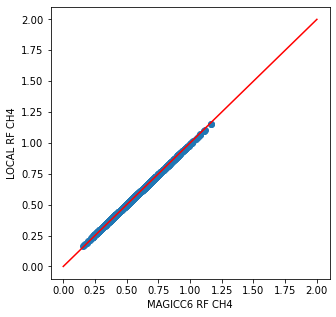

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(MRM,LRM)
plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),c='red')
plt.xlabel("MAGICC6 RF CH4")
plt.ylabel("LOCAL RF CH4")

Text(0, 0.5, 'LOCAL RF N2O')

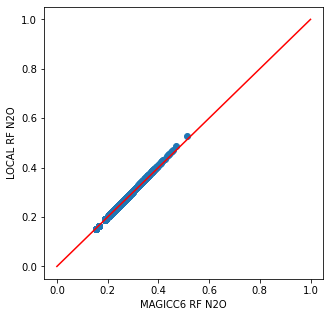

In [53]:
plt.figure(figsize=(5,5))
plt.scatter(MRN,LRN)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),c='red')
plt.xlabel("MAGICC6 RF N2O")
plt.ylabel("LOCAL RF N2O")

In [54]:
dfp['RF3'] = dfp['Diagnostics|MAGICC6|Forcing|CO2'] + dfp['Diagnostics|MAGICC6|Forcing|CH4'] + dfp['Diagnostics|MAGICC6|Forcing|N2O'] 
dfp['RFD'] = dfp['Diagnostics|MAGICC6|Forcing'] - dfp['RF3']

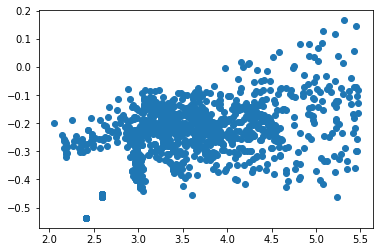

In [55]:
dfpp = dfp[dfp.RF3 < 5.5]
plt.scatter(dfpp.RF3,dfpp.RFD)

In [56]:
## Train multivariate linear regression to fit 

In [57]:
d = dfp[dfp.RF3 < 6][['Diagnostics|MAGICC6|Concentration|CO2','Diagnostics|MAGICC6|Concentration|CH4','Diagnostics|MAGICC6|Concentration|N2O','RFD']].dropna().values
X = d[:,0:3]
y = d[:,3]
rflr = LinearRegression()
rflr.fit(X,y)

def RF_cMAGICC(C,M,N):
    try:
        X_in = np.array([[x,M,N] for x in C])
    except:
        X_in = np.array([[C,M,N]])
    (x,y,z,r) = RF_MAGICC(C,M,N)
    d = rflr.predict(X_in)
    return  d + r

In [58]:
for c in scenarios.columns:
    if c.startswith('RF|'):
        if ('CO2' not in c) and ('CH4' not in c) and ('N2O' not in c):
            s = '|'.join(c.split('|')[1:])
            rc = c.replace('RF|','RFC|')
            cs = ['Concentration|%s|%s' % (gas,s) for gas in gasses]
            scenarios[rc] = scenarios[c] + rflr.predict(scenarios[cs].values) 

## Emissions and Land Carbon Opportunity Cost

we extend the concept of COC (Hayek et al., 2021) to include both emissions and land use changes. We define the “emissions and land carbon opportunity cost” (ELCOC) of dietary interventions as the cumulative reduction in CO2 emissions necessary to reduce the RF projected in a BAU scenario in 2100 to the RF projected following intervention.  

We define the combined emissions and land carbon opportunity cost (ELCOC) of animal agriculture as $2\Delta C$ where:
  
$RF(C_{BAU}-\Delta C,M_{BAU},N_{BAU})=RF(C_{POD},M_{POD},N_{POD})$  

The factor of 2 accounts for the half of $CO_2$ emissions that go to terrestrial sinks.


In [59]:
proj_end = scenarios.iloc[-1]

xl = 300
xh = 700
x = np.linspace(xl,xh,100000)

CB = proj_end['Concentration|CO2|Baseline']
MB = proj_end['Concentration|CH4|Baseline']
NB = proj_end['Concentration|N2O|Baseline']

xd = x - CB
xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
x_R = RF_cMAGICC(x,MB,NB)

data = []

rft = proj_end['RFC|Baseline']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Baseline',rft,xn])

rft = proj_end['RFC|Plant CR|Phaseout Bovids']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Plant CR|Phaseout Bovids',rft, xn])

rft = proj_end['RFC|Plant CR|Phaseout']
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['Plant CR|Phaseout',rft,xn])

rft = 2.6
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['RF2.6',rft,xn])

rft = 1.9
xn = xe[np.argmin(np.abs(x_R-rft))]
data.append(['RF1.9',rft,xn])

elcoc = pd.DataFrame(data=data,columns=['Target','RF','ELCOC'])
elcoc['ELCOC'] = np.round(elcoc.ELCOC,2)
elcoc = elcoc.set_index(['Target'])

In [60]:
elcoc

,RF,ELCOC
Target,,
Baseline,5.107446,0.00
Plant CR|Phaseout Bovids,4.188842,-1.47
Plant CR|Phaseout,3.878344,-1.92
RF2.6,2.600000,-3.52
RF1.9,1.900000,-4.26


In [82]:
1.47/1.92

0.765625

## Land Use if Western Diet Extended to Whole Planet

In [61]:
livestock_data

,Area,Category,Primary Production,Emissions|CO2,Emissions|CH4,Emissions|N2O,Land Use
0,Afghanistan,camel_meat,3667.0,NaN,NaN,NaN,NaN
1,Afghanistan,camel_milk,6809.0,NaN,NaN,NaN,NaN
2,Afghanistan,cattle_meat,95398.0,0.001007,0.153158,0.005177,0.024044
3,Afghanistan,chicken_meat,28493.0,0.000099,0.000074,0.000171,0.000288
4,Afghanistan,cow_milk,1992114.0,0.001634,0.168724,0.006927,0.01773
...,...,...,...,...,...,...,...
1821,Zimbabwe,duck_meat,51.0,0.0,0.0,0.0,0.000001
1822,Zimbabwe,eggs,24480.0,0.000033,0.000174,0.000124,0.000173
1823,Zimbabwe,goat_meat,24829.0,0.000021,0.021145,0.000711,0.003337
1824,Zimbabwe,pig_meat,8891.0,0.000016,0.001005,0.000045,0.000128


In [62]:
country_group

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT
...,...,...,...,...,...,...,...
1913,5000,World,246,Yemen Ar Rp,886.0,NaN,NaN
1914,5000,World,247,Yemen Dem,720.0,NaN,NaN
1915,5000,World,248,Yugoslav SFR,890.0,NaN,NaN
1916,5000,World,251,Zambia,894.0,ZM,ZMB


In [63]:
diet_countries = country_group[country_group['Country Group'] == "OECD"].Country

In [64]:
pop = pd.read_csv("FAOSTAT/Filtered/Population_E_All_Data_(Normalized).csv")
diet_pop_all = pop[(pop.Year == 2018) & (pop.Area.isin(diet_countries))].groupby('Element').sum()
diet_pop = diet_pop_all.loc['Total Population - Both sexes']['Value'] * 1000
diet_pop

1231420762.0

In [65]:
current_pop = 7794798739

In [66]:
(current_pop / diet_pop) *  livestock_data[livestock_data.Area.isin(diet_countries)].groupby('Category').sum().sum()

Primary Production    3.183029e+09
Emissions|CO2         3.862889e+00
Emissions|CH4         1.848331e+02
Emissions|N2O         1.158270e+01
Land Use              7.872311e+01
dtype: float64

# Figures

## Figure Paramters

In [67]:
figw = 8.5
figh = 11

labelw = 90

cap_fontsize = 9
    
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('legend',fontsize=8)
plt.rc('axes',labelsize=9)
plt.rc('axes',titlesize=10)

## Figure 1 - Animal Ag Emissions and Land Use By Species

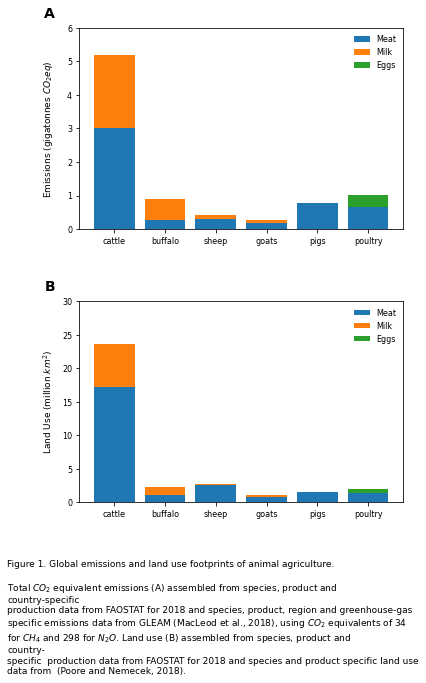

In [68]:
pdffile = "Figures/Figure1.pdf"

with PdfPages(pdffile) as pdf:    
    

    fig = plt.figure(figsize = (figw,figh))

    panelw = 4.5
    panelh = panelw/1.61
    
    label_pos = -.075
    
    margin_top = 1
    
    panelx = (figw - panelw)/2
    panely = figh - margin_top - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    df = livestock_data.groupby('Category').sum()
    df['Emissions'] = df['Emissions|CO2'] + 34/1000 * df['Emissions|CH4'] + 298/1000 * df['Emissions|N2O']
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat'].Emissions,
        df.loc['buffalo_meat'].Emissions,
        df.loc['sheep_meat'].Emissions,
        df.loc['goat_meat'].Emissions,
        df.loc['pig_meat'].Emissions,
        df.loc['chicken_meat'].Emissions + df.loc['duck_meat'].Emissions,
        ])

    plot_milk = np.array([
        df.loc['cow_milk'].Emissions,
        df.loc['buffalo_milk'].Emissions,
        df.loc['sheep_milk'].Emissions,
        df.loc['goat_milk'].Emissions,
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'].Emissions,
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Emissions (gigatonnes $CO_{2}eq$)')
    ax.set_ylim(0,6)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.05,"A",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    margin_between = 1
    
    panelx = (figw - panelw)/2
    panely -= panelh + margin_between
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    plot_meat = np.array([
        df.loc['cattle_meat']['Land Use'],
        df.loc['buffalo_meat']['Land Use'],
        df.loc['sheep_meat']['Land Use'],
        df.loc['goat_meat']['Land Use'],
        df.loc['pig_meat']['Land Use'],
        df.loc['chicken_meat']['Land Use'] + df.loc['duck_meat']['Land Use'], 
    ])

    plot_milk = np.array([
        df.loc['cow_milk']['Land Use'],
        df.loc['buffalo_milk']['Land Use'],
        df.loc['sheep_milk']['Land Use'],
        df.loc['goat_milk']['Land Use'],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs']['Land Use'],
    ])

    p1 = ax.bar(plot_species,plot_meat)
    p2 = ax.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = ax.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    ax.set_ylabel(r'Land Use (million $km^2$)')
    ax.set_ylim(0,30)
    ax.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), frameon=False)
    ax.text(label_pos,1.05,"B",transform=ax.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    ax.yaxis.set_label_coords(label_pos,0.5,transform=ax.transAxes)
    
    
    flh = r"Figure 1. Global emissions and land use footprints of animal agriculture."
    
    flt = r'''Total $CO_2$ equivalent emissions (A) assembled from species, product and country-specific 
production data from FAOSTAT for 2018 and species, product, region and greenhouse-gas 
specific emissions data from GLEAM (MacLeod et al., 2018), using $CO_2$ equivalents of 34 
for $CH_4$ and 298 for $N_{2}O$. Land use (B) assembled from species, product and country-specific 
production data from FAOSTAT for 2018 and species and product specific land use data from 
(Poore and Nemecek, 2018). 
'''
    
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    
    
    

## Figure 1-S1 - Animal Ag Emissions and Gas and Species

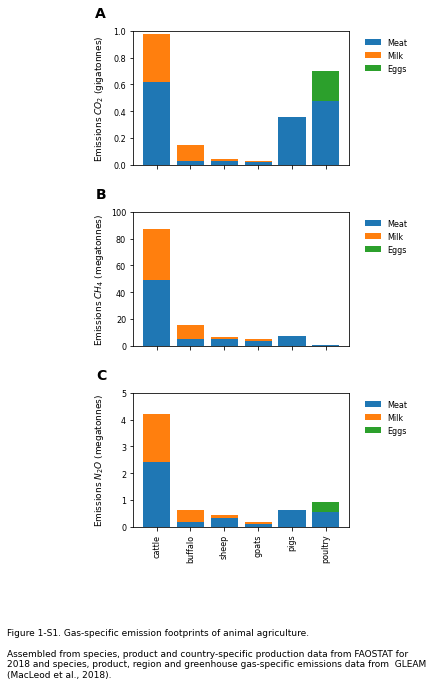

In [69]:
pdffile = "Figures/Figure1-S1.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))

    panelw = 3
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = (figw - panelw)/2
    panely = figh - margin_top - panelh
    
    panel_margin = .65
    
    df = livestock_data.groupby('Category').sum()
    plot_species = ['cattle','buffalo','sheep','goats','pigs','poultry']
    
    axA = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CO2" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pA1 = axA.bar(plot_species,plot_meat)
    pA2 = axA.bar(plot_species,plot_milk,bottom=plot_meat)
    pA3 = axA.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axA.set_ylabel(r"Emissions $CO_{2}$ (gigatonnes)")
    axA.set_ylim(0,1.0)
    axA.text(-.125,1.1,"A",transform=axA.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axA.set_xticks(np.arange(0,len(plot_species)))
    axA.set_xticklabels([])
    axA.yaxis.set_label_coords(-0.125,0.5,transform=axA.transAxes)
    axA.legend((pA1[0], pA2[0], pA3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))

    panely -= panelh + panel_margin
    
    axB = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|CH4" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    pB1 = axB.bar(plot_species,plot_meat)
    pB2 = axB.bar(plot_species,plot_milk,bottom=plot_meat)
    pB3 = axB.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axB.set_ylabel(r"Emissions $CH_{4}$ (megatonnes)")
    axB.set_ylim(0,100)
    axB.text(-.125,1.1,"B",transform=axB.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axB.set_xticks(np.arange(0,len(plot_species)))
    axB.set_xticklabels([])
    axB.yaxis.set_label_coords(-0.125,0.5)
    axB.legend((pB1[0], pB2[0], pB3[0]), ('Meat', 'Milk','Eggs'), loc='upper left',frameon=False,bbox_to_anchor=(1.04,1.0))
   
    
    panely -= panelh + panel_margin
    
    axC = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    c = "Emissions|N2O" 

    plot_meat = np.array([
        df.loc['cattle_meat'][c],
        df.loc['buffalo_meat'][c],
        df.loc['sheep_meat'][c],
        df.loc['goat_meat'][c],
        df.loc['pig_meat'][c],
        df.loc['chicken_meat'][c] + df.loc['duck_meat'][c],
    ])

    plot_milk = np.array([
        df.loc['cow_milk'][c],
        df.loc['buffalo_milk'][c],
        df.loc['sheep_milk'][c],
        df.loc['goat_milk'][c],
        0,
        0,
    ])

    plot_eggs = np.array([
        0,
        0,
        0,
        0,
        0,
        df.loc['eggs'][c],
    ])

    p1 = axC.bar(plot_species,plot_meat)
    p2 = axC.bar(plot_species,plot_milk,bottom=plot_meat)
    p3 = axC.bar(plot_species,plot_eggs,bottom=plot_meat + plot_milk)
    axC.set_ylabel(r"Emissions $N_{2}O$ (megatonnes)")
    axC.set_ylim(0,5)
    axC.text(-.125,1.1,"C",transform=axC.transAxes,fontsize=14,fontweight='bold',horizontalalignment='right')
    axC.set_xticks(np.arange(0,len(plot_species)))
    axC.set_xticklabels(plot_species,rotation=90)
    axC.yaxis.set_label_coords(-0.125,0.5)
    axC.legend((p1[0], p2[0], p3[0]), ('Meat', 'Milk','Eggs'), loc='upper left', frameon=False, bbox_to_anchor=(1.04,1.0))            
        
    
    flh = r"Figure 1-S1. Gas-specific emission footprints of animal agriculture."
    
    flt = r'''Assembled from species, product and country-specific production data from FAOSTAT for 
2018 and species, product, region and greenhouse gas-specific emissions data from 
GLEAM (MacLeod et al., 2018).'''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    
    pdf.savefig()
    
    

## Figure 2 - Comparing Baseline, Phaseout of Bovids and Phaseout of all Livestock 

Function creates different versions for different subsets of data

In [70]:
def Figure2(plotname,plotlabel,plotcaption,scen,scenlabel,scen2="",scen2label=""):

    pdffile = "Figures/%s.pdf" % plotname

    with PdfPages(pdffile) as pdf:    

        figw = 8.5
        figh = 11

        fig = plt.figure(figsize = (figw,figh))

        panelw = 2
        panelh = panelw/1.61

        margin_top = 1
        margin_between = .75

        x = [1.5,7 - panelw]
        y = [figh - 1 - (i+1) * panelh - i * (margin_between) for i in [0,1,2,3]]

        ax = [[],[],[],[]]

        for j in [0,1,2,3]:
            for i in [0,1]:
                ax[j].append(fig.add_axes([x[i]/figw,y[j]/figh,panelw/figw,panelh/figh]))

        units = {
            'CO2' : "Gt/year",
            'CH4' : "Mt/year",
            'N2O' : "Mt/year"
        }

        pp_units = {
            'CO2' : "ppm",
            'CH4' : "ppb",
            'N2O' : "ppb"
        }


        factor = {
            'CO2' : 1,
            'CH4' : 1,
            'N2O' : 1
        }

        label_pos = -0.2

        for ai,gas in enumerate(gasses):
            for i,r in scenarios.groupby('SCENARIO'):
                l1 = ax[ai][0].plot(r.Year,r['Emissions|%s|Total|Baseline' % gas],c='red')
                l2 = ax[ai][0].plot(r.Year,r['Emissions|%s|Total|%s' % (gas,scen)],c='green')
                l3 = ""
                if scen2 != "":
                    l3 = ax[ai][0].plot(r.Year,r['Emissions|%s|Total|%s' % (gas,scen2)],c='green',linestyle='dashed')
                ax[ai][1].plot(r.Year,r['Concentration|%s|Baseline' % gas],c='red')
                ax[ai][1].plot(r.Year,r['Concentration|%s|%s' % (gas,scen)],c='green')
                if scen2 != "":
                    ax[ai][1].plot(r.Year,r['Concentration|%s|%s' % (gas,scen2)],c='green', linestyle='dashed')

            ax[ai][0].set_title("Emissions " + gas, fontsize=8)
            ax[ai][1].set_title("Atmospheric Concentration " + gas, fontsize=8)
            ax[ai][0].set_ylabel(units[gas],fontsize=8)
            ax[ai][0].set_ylim(0,)
            ax[ai][1].set_ylabel(pp_units[gas],fontsize=8)
            ax[ai][0].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][1].yaxis.set_label_coords(label_pos,0.5)
            ax[ai][0].set_xlabel("Year",fontsize=8)
            ax[ai][1].set_xlabel("Year",fontsize=8)

        for i,r in scenarios.groupby('SCENARIO'):
            ax[3][1].plot(r.Year,r['RF|Baseline'],c='red')
            ax[3][1].plot(r.Year,r['RF|%s' %scen],c='green')
            if scen2 != "":
                ax[3][1].plot(r.Year,r['RF|%s' %scen2],c='green',linestyle='dashed')
            ax[3][1].set_title("Combined Global Warming Impact", fontsize=8)
            ax[3][1].yaxis.set_label_coords(label_pos,0.5)


        ax[0][0].text(label_pos,1.2,"A",transform=ax[0][0].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[0][1].text(label_pos,1.2,"B",transform=ax[0][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')
        ax[3][1].text(label_pos,1.2,"C",transform=ax[3][1].transAxes,fontsize=14,fontweight='bold',horizontalalignment = 'right')

        # Set tick font size

        for i in range(0,4):
            for j in range(0,2):
                for label in (ax[i][j].get_xticklabels() + ax[i][j].get_yticklabels()):
                    label.set_fontsize(8)



        ax[3][0].set_visible(False)
        ax[3][1].set_ylabel(r"Radiative Forcing $Wm^{-2}$",fontsize=8)                


        legend_lines = [
            Line2D([0],[0],color='red', lw=2),
            Line2D([0],[0],color='green', lw=2),
        ]
        
        legend_labels = [
            'Business as Usual Diet',
            scenlabel,
        ]
            
        if scen2 != "":
            legend_lines = [
                Line2D([0],[0],color='red', lw=2),
                Line2D([0],[0],color='green', lw=2, linestyle='dashed'),
                Line2D([0],[0],color='green', lw=2),
            ]
    
            legend_labels = [
                'Business as Usual Diet',
                scen2label,
                scenlabel,
            ]


        plt.legend(legend_lines,legend_labels,bbox_to_anchor=(-.75,.5), borderaxespad=0, frameon=False)

        flh = plotlabel

        flt = plotcaption 
        
        annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

        plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

        pdf.savefig()
    

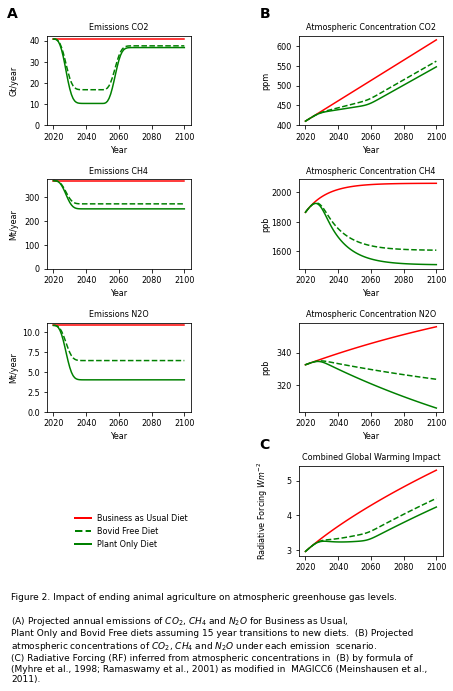

In [71]:
plotname = "Figure2"
plotlabel = r"Figure 2. Impact of ending animal agriculture on atmospheric greenhouse gas levels."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual, 
Plant Only and Bovid Free diets assuming 15 year transitions to new diets. 
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under each emission 
scenario. (C) Radiative Forcing (RF) inferred from atmospheric concentrations in 
(B) by formula of (Myhre et al., 1998; Ramaswamy et al., 2001) as modified in 
MAGICC6 (Meinshausen et al., 2011).'''

plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

scen = "Plant CR|Phaseout"
scenlabel = "Plant Only Diet"
scen2 = "Plant CR|Phaseout Bovids"
scen2label = "Bovid Free Diet"


Figure2(plotname,plotlabel,plotcaption,scen,scenlabel,scen2,scen2label)


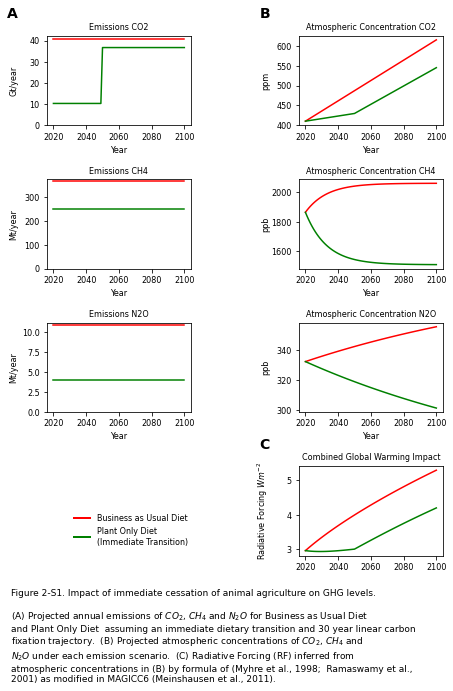

In [72]:
plotname = "Figure2-S1"
plotlabel = r"Figure 2-S1. Impact of immediate cessation of animal agriculture on GHG levels."
plotcaption = r'''(A) Projected annual emissions of $CO_2$, $CH_4$ and $N_{2}O$ for Business as Usual Diet and Plant Only Diet 
assuming an immediate dietary transition and 30 year linear carbon fixation trajectory. 
(B) Projected atmospheric concentrations of $CO_2$, $CH_4$ and $N_{2}O$ under each emission scenario. 
(C) Radiative Forcing (RF) inferred from atmospheric concentrations in (B) by formula of (Myhre et al., 1998; 
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011).'''
scen = "Plant CR"
scenlabel = "Plant Only Diet\n(Immediate Transition)"
Figure2(plotname,plotlabel,plotcaption,scen,scenlabel)


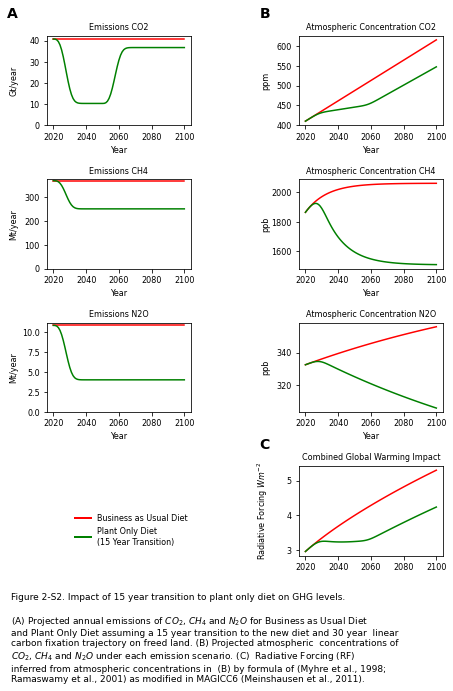

In [73]:
plotname = "Figure2-S2"
plotlabel = r"Figure 2-S2. Impact of 15 year transition to plant only diet on GHG levels."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual Diet 
and Plant Only Diet assuming a 15 year transition to the new diet and 30 year 
linear carbon fixation trajectory on freed land. (B) Projected atmospheric 
concentrations of CO2, CH4 and N2O under each emission scenario. (C) 
Radiative Forcing (RF) inferred from atmospheric concentrations in 
(B) by formula of (Myhre et al., 1998; Ramaswamy et al., 2001) as modified in
MAGICC6 (Meinshausen et al., 2011).'''
scen = "Plant CR|Phaseout"
scenlabel = "Plant Only Diet\n(15 Year Transition)"
plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

Figure2(plotname,plotlabel,plotcaption,scen,scenlabel)


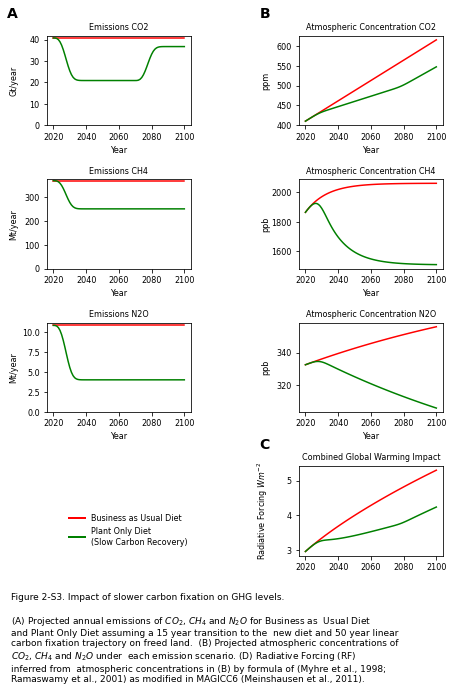

In [74]:
plotname = "Figure2-S3"
plotlabel = r"Figure 2-S3. Impact of slower carbon fixation on GHG levels."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as 
Usual Diet and Plant Only Diet assuming a 15 year transition to the 
new diet and 50 year linear carbon fixation trajectory on freed land. 
(B) Projected atmospheric concentrations of CO2, CH4 and N2O under 
each emission scenario. (D) Radiative Forcing (RF) inferred from 
atmospheric concentrations in (B) by formula of (Myhre et al., 1998; 
Ramaswamy et al., 2001) as modified in MAGICC6 (Meinshausen et al., 2011).'''
scen = "Plant Slow CR|Phaseout"
scenlabel = "Plant Only Diet\n(Slow Carbon Recovery)"
plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

Figure2(plotname,plotlabel,plotcaption,scen,scenlabel)


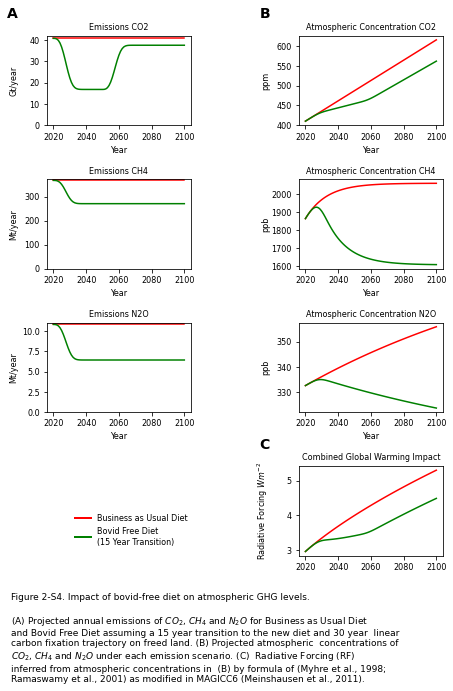

In [75]:
plotname = "Figure2-S4"
plotlabel = r"Figure 2-S4. Impact of bovid-free diet on atmospheric GHG levels."
plotcaption = r'''(A) Projected annual emissions of CO2, CH4 and N2O for Business as Usual Diet 
and Bovid Free Diet assuming a 15 year transition to the new diet and 30 year 
linear carbon fixation trajectory on freed land. (B) Projected atmospheric 
concentrations of CO2, CH4 and N2O under each emission scenario. (C) 
Radiative Forcing (RF) inferred from atmospheric concentrations in 
(B) by formula of (Myhre et al., 1998; Ramaswamy et al., 2001) as modified in
MAGICC6 (Meinshausen et al., 2011).'''
scen = "Plant CR|Phaseout Bovids"
scenlabel = "Bovid Free Diet\n(15 Year Transition)"
plotcaption = plotcaption.replace("CO2",r"$CO_2$")
plotcaption = plotcaption.replace("CH4",r"$CH_4$")
plotcaption = plotcaption.replace("N2O",r"$N_{2}O$")

Figure2(plotname,plotlabel,plotcaption,scen,scenlabel)

## Figure 3 Carbon Opportunity for Eliminating Animal Ag

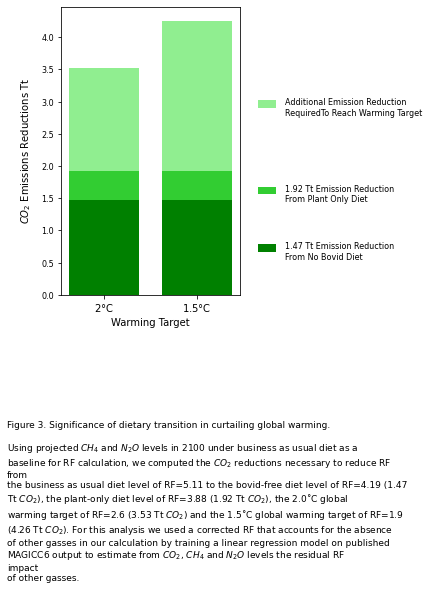

In [76]:
proj_end = scenarios.iloc[-1]

pdffile = "Figures/Figure3.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))

    panelh = 4
    panelw = panelh/1.61
    
    margin_top = 2

    panelx = 1.75
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])


    # Data from Figure 3-S1 below
    
    labels = [r'2$\degree$C','1.5$\degree$C']
    
    ec = -elcoc.loc['Plant CR|Phaseout']['ELCOC']
    plant = [ec,ec]
    ec = -elcoc.loc['Plant CR|Phaseout Bovids']['ELCOC']
    nobo = [ec,ec]
    ec1 = -elcoc.loc['RF2.6']['ELCOC']
    ec2 = -elcoc.loc['RF1.9']['ELCOC']
    rftarget = [ec1,ec2]
    width=.75
    
    l1 = ax.bar(labels,rftarget,width=width,color='lightgreen',label="Additional Emission Reductions Required to Reach Warming Target")
    l2 = ax.bar(labels,plant,width=width,color='limegreen',label='Additional Emission Reductions From Plant Only Diet')
    l3 = ax.bar(labels,nobo,width=width,color='green',label='Emission Reductions From No Bovid Diet')
    
    ax.set_ylabel(r"$CO_{2}$ Emissions Reductions Tt",fontsize=10)
    
    ax.set_xticks(np.arange(0,len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    #ax.legend(bbox_to_anchor=(1,1.25), borderaxespad=0,fontsize=9,frameon=False)
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    ax.yaxis.set_label_coords(-2.1333333333333333 * .075,0.5)
    ax.set_xlabel("Warming Target",fontsize=10)
    
    

# Add the patch to the Axes

    flh = r"Figure 3. Significance of dietary transition in curtailing global warming."
    
    flt = r'''Using projected CH4 and N2O levels in 2100 under business as usual diet
as a baseline for RF calculation, we computed the CO2 reductions necessary
to reduce RF from the business as usual diet level of RF=5.11 to the bovid-free diet
level of RF=4.19 (1.47 Tt CO2), the plant-only diet level of RF=3.88 (1.92 Tt CO2),
the 2.0˚C global warming target of RF=2.6 (3.53 Tt CO2) and the 1.5˚C global warming
target of RF=1.9 (4.26 Tt CO2). For this analysis we used a corrected RF that accounts
for the absence of other gasses in our calculation by training a linear
regression model on published MAGICC6 output to estimate from CO2, CH4 and N2O
levels the residual RF impact of other gasses. '''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    h = .15
    ax.text(1.25,h,"1.47 Tt Emission Reduction\nFrom No Bovid Diet",fontsize=8,transform=ax.transAxes, verticalalignment='center')
    rect = patches.Rectangle((1.1,h), .1, .025, transform=ax.transAxes, clip_on = False, linewidth=0, facecolor='green')
    ax.add_patch(rect)
    
    h = .35
    ax.text(1.25,h,"1.92 Tt Emission Reduction\nFrom Plant Only Diet",fontsize=8,transform=ax.transAxes, verticalalignment='center')
    rect = patches.Rectangle((1.1,h), .1, .025, transform=ax.transAxes, clip_on = False, linewidth=0,  facecolor='limegreen')
    ax.add_patch(rect)
    
    h = .65
    ax.text(1.25,h,"Additional Emission Reduction\nRequiredTo Reach Warming Target",fontsize=8,transform=ax.transAxes, verticalalignment='center')
    rect = patches.Rectangle((1.1,h), .1, .025, transform=ax.transAxes, clip_on = False, linewidth=0,  facecolor='lightgreen')
    ax.add_patch(rect)
    
    
    pdf.savefig()

## Figure 3-S1

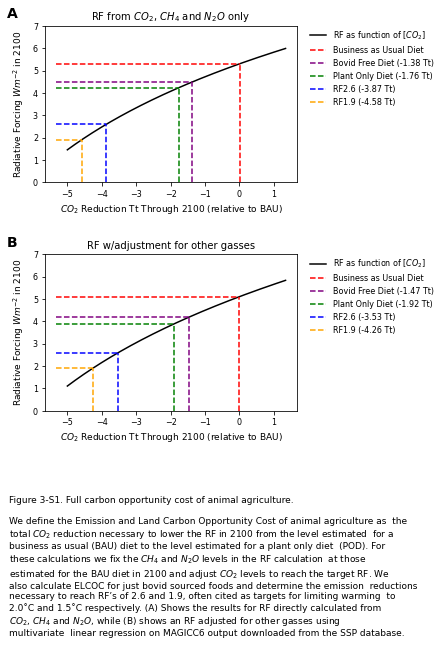

In [77]:
proj_end = scenarios.iloc[-1]

pdffile = "Figures/Figure3-S1.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))
    
    
    proj_end = scenarios.iloc[-1]

    panelw = 3.5
    panelh = panelw/1.61
    
    margin_top = 1.5

    panelx = 1.5
    panely = figh - margin_top - panelh
        
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,500)

    CB = proj_end['Concentration|CO2|Baseline']
    MB = proj_end['Concentration|CH4|Baseline']
    NB = proj_end['Concentration|N2O|Baseline']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    (x_C,x_M,x_N,x_R) = RF_MAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RF|Baseline']))]
    ax.plot([px[0],xn],[proj_end['RF|Baseline'],proj_end['RF|Baseline']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RF|Baseline']],c='red',linestyle='dashed')
    
    rft = proj_end['RF|Plant CR|Phaseout Bovids']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RF|Plant CR|Phaseout']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)

    ax.text(-.15,1.05,"A",transform=ax.transAxes,fontsize=14,fontweight='bold')
    title = r"RF from $CO_2$, $CH_4$ and $N_{2}O$ only"
    ax.set_title(title)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)

    
    panely = figh - margin_top - panelh - 1.0 - panelh
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    ax.set_ylim(0,7)
    
    xl = 300
    xh = 700
    x = np.linspace(xl,xh,1000)

    CB = proj_end['Concentration|CO2|Baseline']
    MB = proj_end['Concentration|CH4|Baseline']
    NB = proj_end['Concentration|N2O|Baseline']

    xd = x - CB
    xe = 2 * xd * 44 * 1.8E11 / 1E12 / 1000
    x_R = RF_cMAGICC(x,MB,NB)

    ax.plot(xe,x_R,label=r'RF as function of [$CO_{2}$]',c='black')
    px = plt.xlim()
    py = plt.ylim()

    xn = xe[np.argmin(np.abs(x_R-proj_end['RFC|Baseline']))]
    ax.plot([px[0],xn],[proj_end['RFC|Baseline'],proj_end['RFC|Baseline']],c='red',label='Business as Usual Diet',linestyle='dashed')
    ax.plot([xn,xn],[py[0],proj_end['RFC|Baseline']],c='red',linestyle='dashed')
    
    rft = proj_end['RFC|Plant CR|Phaseout Bovids']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='purple',label='Bovid Free Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='purple',linestyle='dashed')
    
    rft = proj_end['RFC|Plant CR|Phaseout']
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='green',label='Plant Only Diet (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='green',linestyle='dashed')

    rft = 2.6
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='blue',label='RF2.6 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='blue',linestyle='dashed')

    rft = 1.9
    xn = xe[np.argmin(np.abs(x_R-rft))]
    ax.plot([px[0],xn],[rft,rft],c='orange',label='RF1.9 (%.2f Tt)' %xn,linestyle='dashed')
    ax.plot([xn,xn],[py[0],rft],c='orange',linestyle='dashed')
    ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,frameon=False)
    ax.set_xlabel(r"$CO_{2}$ Reduction Tt Through 2100 (relative to BAU)")
    ax.set_ylabel(r"Radiative Forcing $Wm^{-2}$ in 2100")    
    ax.yaxis.set_label_coords(-0.075,0.5)
    
    ax.text(-.15,1.05,"B",transform=ax.transAxes,fontsize=14,fontweight='bold')
    ax.set_title("RF w/adjustment for other gasses")
    
    #for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #    label.set_fontsize(8)
    
    flh = r"Figure 3-S1. Full carbon opportunity cost of animal agriculture."
    
    flt = r'''We define the Emission and Land Carbon Opportunity Cost of animal agriculture as 
the total CO2 reduction necessary to lower the RF in 2100 from the level estimated 
for a business as usual (BAU) diet to the level estimated for a plant only diet 
(POD). For these calculations we fix the CH4 and N2O levels in the RF calculation 
at those estimated for the BAU diet in 2100 and adjust CO2 levels to reach the target RF.
We also calculate ELCOC for just bovid sourced foods and determine the emission 
reductions necessary to reach RF’s of 2.6 and 1.9, often cited as targets for limiting warming 
to 2.0˚C and 1.5˚C respectively. (A) Shows the results for RF directly calculated from 
CO2, CH4 and N2O, while (B) shows an RF adjusted for other gasses using multivariate 
linear regression on MAGICC6 output downloaded from the SSP database.'''
    
    flt = flt.replace("CO2",r"$CO_2$")
    flt = flt.replace("CH4",r"$CH_4$")
    flt = flt.replace("N2O",r"$N_{2}O$")

    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")

    pdf.savefig()
    

## Figure 4

In [78]:
dfp['SSP'] = dfp.Scenario.apply(lambda x: x.split('-')[0])
dfp['SSP-TARGET'] = dfp.Scenario.apply(lambda x: x.split('-')[1])

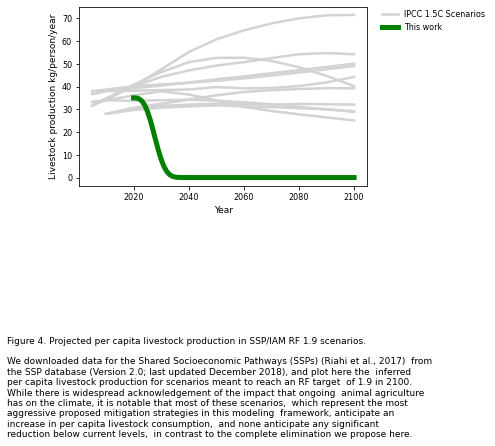

In [79]:

pdffile = "Figures/Figure4.pdf"

with PdfPages(pdffile) as pdf:    
    
    figw = 8.5
    figh = 11
    
    fig = plt.figure(figsize = (figw,figh))

    panelw = 4
    panelh = panelw/1.61
    
    margin_top = 1
    
    panelx = 2.0
    panely = figh - margin_top - panelh - 3
    
    ax = fig.add_axes([panelx/figw,panely/figh,panelw/figw,panelh/figh])
    
    dfpw19 = dfp[(dfp.Region == "World") & (dfp['SSP-TARGET'] == '19')].copy()
    dfpw19.Year = dfpw19.Year.astype('int64')
    for i,r in dfpw19.groupby(['Model','Scenario']):
        ax.plot(r.Year,1e+3 * r['Agricultural Production|Livestock']/r['Population'],c='lightgrey',linewidth=2.5)
    
    ax.plot(scenarios.Year,scenarios.aa_exponential_phaseout * 35, c='green', linewidth = 5)
    
    ax.set_xticks([2020,2040,2060,2080,2100])
    ax.set_xlabel("Year")
    ax.set_ylabel("Livestock production kg/person/year")
    
    legend_lines = [
        Line2D([0],[0],color='lightgrey', lw=2.5),
        Line2D([0],[0],color='green', lw=5),
    ]

    legend_labels = [
        'IPCC 1.5C Scenarios',
        'This work',
    ]

    plt.legend(legend_lines,legend_labels,bbox_to_anchor=(1.04,1.0), borderaxespad=0, frameon=False)

    
    flh = "Figure 4. Projected per capita livestock production in SSP/IAM RF 1.9 scenarios."
    
    flt = '''\
    We downloaded data for the Shared Socioeconomic Pathways (SSPs) (Riahi et al., 2017) 
    from the SSP database (Version 2.0; last updated December 2018), and plot here the 
    inferred per capita livestock production for scenarios meant to reach an RF target 
    of 1.9 in 2100. While there is widespread acknowledgement of the impact that ongoing 
    animal agriculture has on the climate, it is notable that most of these scenarios, 
    which represent the most aggressive proposed mitigation strategies in this modeling 
    framework, anticipate an increase in per capita livestock consumption, 
    and none anticipate any significant reduction below current levels, 
    in contrast to the complete elimination we propose here.
    '''
    annot_txt = flh + "\n\n" + tw.fill(tw.dedent(flt.rstrip()), width=labelw)

    plt.figtext(1/figw, 1/figh, annot_txt, horizontalalignment='left', verticalalignment='bottom', fontsize=cap_fontsize, multialignment='left', wrap="True")
        
    pdf.savefig()
    
    
    
    


